In [48]:
%matplotlib inline
import lightgbm as lgb
import numpy as np
import pandas as pd
import random
from scipy.stats import norm
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from bs4 import BeautifulSoup
import re
from bayes_opt import BayesianOptimization
import graphviz
import warnings
warnings.simplefilter('ignore')
def make_Xyqodds():
    result = [[[],[],[],[]],[[],[],[],[]]]
    with open("keiba_2019",mode="r") as f:
        for line in f.readlines():
          
            year = int(line[0:4])
            if year < 2020:
                num = 0
            else:
                num = 1
        
            
            line_list = line.split(",")
            race_info,horses_info,odds_info = line_list[0],line_list[1:-1],line_list[-1]
            race_list = race_info.split(";")
            
            for horse_info in horses_info:
                horse_list = horse_info.split(";")
                label = int(18/int(horse_list[0]))
                data = race_list + horse_list[1:] +[race_list[0][4:6],race_list[0][-2:]]
                for i in [2,5,8,10,11,12,18]:
                    try:
                        data[i] = float(data[i])
                    except:
                        data[i] = 0
                result[num][0].append(data)
                result[num][1].append(label)
            
            result[num][2].append(len(horses_info))
            result[num][3].append(odds_info)
    result = np.array(result)

    return result
def train_sim(max_depth,num_leaves,max_position):
    
    boosting_type = "gbdt"
    
    result = make_Xyqodds()
    X_train,X_test = result[0][0],result[1][0]
    y_train,y_test = result[0][1],result[1][1]
    q_train,q_test = result[0][2],result[1][2]
    odds_train,odds_test = result[0][3],result[1][3]
    category = [0,1,3,4,6,7,9,13,14,15,16,17,19,20]
    number =[2,5,8,10,11,12,18]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    for i in category:
        X_train[i] = X_train[i].astype('category')
        X_test[i] = X_test[i].astype('category')
    #for i in number:
        #X_train[i] = X_train[i].astype('float')
        #X_test[i] = X_test[i].astype('float')
    #columns_name = []
    
    X_train.drop(columns=10,inplace=True) 
    X_test.drop(columns=10,inplace=True) 

    train = lgb.Dataset(X_train, y_train,group=q_train)
    test = lgb.Dataset(X_test, y_test, group=q_test)

    params = { 
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'ndcg_eval_at': 3,
        'max_depth': int(max_depth),
        'max_position':int(max_position), 
        'num_leaves': int(num_leaves),
        'min_data_in_leaf':1,
        'verbose': -1,
        'categorical_feature':category,
        'boosting_type': boosting_type
    }
    #print(type(X_train.loc[0,2]))
    model = lgb.train(
        params,
        train,
        num_boost_round=150,
        valid_sets=[train,test],
        valid_names=['train','test'],
        early_stopping_rounds=20,
        verbose_eval=True
    )

    from_ = 0
    odds_all = odds_test
   
    
    gain = [[],[],[],[],[],[],[]]
    hit = [0,0,0,0,0,0,0]
    
    for i,odds in zip(q_test,odds_all):
        pred = model.predict(X_test[from_:from_+i],num_iteration=model.best_iteration)
        pred = pd.Series(pred).sort_values(ascending=False)          
        pred.index = pred.index + 1
        pred_rank = list(map(str,pred.index.values))[0:3]

        from_ += i
        odds_list = re.findall(r'([^\|]*)\|([^\|]*)\|([^;]*)円;?',odds)

        result = []
        for i,j in zip([1,2],[" ","円"]):
            comb_list =  [x[i] for x in odds_list if x[0] != "枠連"]
            comb_list[0] = [comb_list[0:1]]
            comb_list[1] = [[a] for a in comb_list[1].split(j)]
            if len(comb_list[1]) == 5:
                comb_list[1] = comb_list[1][::2]
                j = "   "
            comb_list[2] = [set(comb_list[2].split(j))]
            comb_list[3] = comb_list[3].split(j)
            comb_list[3] = [set(comb_list[3][0:(3-i)]),set(comb_list[3][3-i:6-2*i]),set(comb_list[3][6-2*i:9-3*i])]
            comb_list[4] = [comb_list[4].split(j)]
            comb_list[5] = [set(comb_list[5].split(j))]
            comb_list[6] = [comb_list[6].split(j)]
            result.append(comb_list)

        baken_list = [0,0,0,0,0,0,0,0]
        baken_list[0] = [[a] for a in pred_rank[0:1]]
        baken_list[1] = [[a] for a in pred_rank[0:3]]
        baken_list[2] = [set(pred_rank[0:2])]
        baken_list[3] = [set(pred_rank[0:2]),set(pred_rank[1:3]),set(pred_rank[::2])]
        baken_list[4] = [pred_rank[0:2]]
        baken_list[5] = [set(pred_rank)]
        baken_list[6] = [pred_rank]
        
        for k in range(len(result[0])):
            for j in range(len(result[0][k])):
                if result[0][k][j] in baken_list[k]:
                    gain[k].append(float(list(result[1][k][j])[0]))
                    hit[k] += 1
                    
                else:
                    gain[k].append(0)
                


 
    gain = np.array(gain)
    objective = []
    for i in range(7):
        p = norm.sf(x=100,loc=np.average(gain[i]),scale=np.std(gain[i],ddof=1)/np.sqrt(len(gain[i])))
        print(p,hit[i]/len(gain[i]),np.average(gain[i]),np.std(gain[i],ddof=1)/np.sqrt(len(gain[i])))
        
    importance = pd.DataFrame(model.feature_importance(), index=X_train.columns.values, columns=['importance'])
    display(importance)
    return model

In [46]:
import pickle
model = train_sim(4,16,3) #max_depth,num_leaves,max_position

#pickle.dump(model, open('trained_model.pkl', 'wb'))


,0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20
0,201501010101,芝,1500.0,晴,良,500.0,01,01,1.0,コスモベガス,0,14.7,476,0,古賀史生 (美浦),伊丹彰,鮫川啓一,0,アイノサウスポー,70.0
1,201501010101,芝,1500.0,晴,良,500.0,01,01,2.0,マカーオーン,0,7.3,466,-2,小桧山悟 (美浦),小野建,三好牧場,0,システィンチャペル,180.0
2,201501010101,芝,1500.0,晴,良,500.0,01,01,3.0,ジュンノキボウ,0,90.1,470,0,藤沢和雄 (美浦),山本英俊,社台ファーム,0,リトミックダンス,240.0
3,201501010101,芝,1500.0,晴,良,500.0,01,01,4.0,マイネルアクティヴ,0,142.9,422,0,渡辺薫彦 (栗東),サンデーレーシング,ノーザンファーム,0,ルミナスポイント,280.0
4,201501010101,芝,1500.0,晴,良,500.0,01,01,5.0,サフランナイト,0,235.2,410,-6,池上昌弘 (美浦),ヒダカ・ブリーダーズ・ユニオン,矢野牧場,0,マリアージュ,410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212938,201909050911,ダ,1800.0,曇,稍,2300.0,09,11,12.0,メイプルブラザー,0,22.6,498,+2,西園正都 (栗東),谷口屯,宮内牧場,0,タムロイーネー,14834.599999999999
212939,201909050911,ダ,1800.0,曇,稍,2300.0,09,11,13.0,ブラックバゴ,0,170.0,518,+2,安達昭夫 (栗東),松本好雄,隆栄牧場,0,シールビーバック,18972.5
212940,201909050911,ダ,1800.0,曇,稍,2300.0,09,11,14.0,メイショウウタゲ,0,208.4,516,+4,高木登 (美浦),サラブレッドクラブ・ラフィアン,ビッグレッドファーム,0,マイネヌーヴェル,8619.8
212941,201909050911,ダ,1800.0,曇,稍,2300.0,09,11,15.0,サトノプライム,0,34.6,504,+2,水野貴広 (美浦),助川啓一,大狩部牧場,0,フェニックスワン,7298.8


[1]	train's ndcg@3: 0.492586	test's ndcg@3: 0.511027
Training until validation scores don't improve for 20 rounds
[2]	train's ndcg@3: 0.513886	test's ndcg@3: 0.528421
[3]	train's ndcg@3: 0.522477	test's ndcg@3: 0.527173
[4]	train's ndcg@3: 0.525067	test's ndcg@3: 0.529553
[5]	train's ndcg@3: 0.529729	test's ndcg@3: 0.529062
[6]	train's ndcg@3: 0.534255	test's ndcg@3: 0.532561
[7]	train's ndcg@3: 0.537916	test's ndcg@3: 0.533943
[8]	train's ndcg@3: 0.542481	test's ndcg@3: 0.529498
[9]	train's ndcg@3: 0.544598	test's ndcg@3: 0.525304
[10]	train's ndcg@3: 0.550626	test's ndcg@3: 0.528812
[11]	train's ndcg@3: 0.553847	test's ndcg@3: 0.529059
[12]	train's ndcg@3: 0.557806	test's ndcg@3: 0.537022
[13]	train's ndcg@3: 0.560525	test's ndcg@3: 0.535589
[14]	train's ndcg@3: 0.562868	test's ndcg@3: 0.538354
[15]	train's ndcg@3: 0.565392	test's ndcg@3: 0.536968
[16]	train's ndcg@3: 0.566897	test's ndcg@3: 0.537664
[17]	train's ndcg@3: 0.569093	test's ndcg@3: 0.536481
[18]	train's ndcg@3: 0.570831	

,importance
0,1
1,5
2,24
3,7
4,13
5,51
6,1
7,1
8,33
9,62


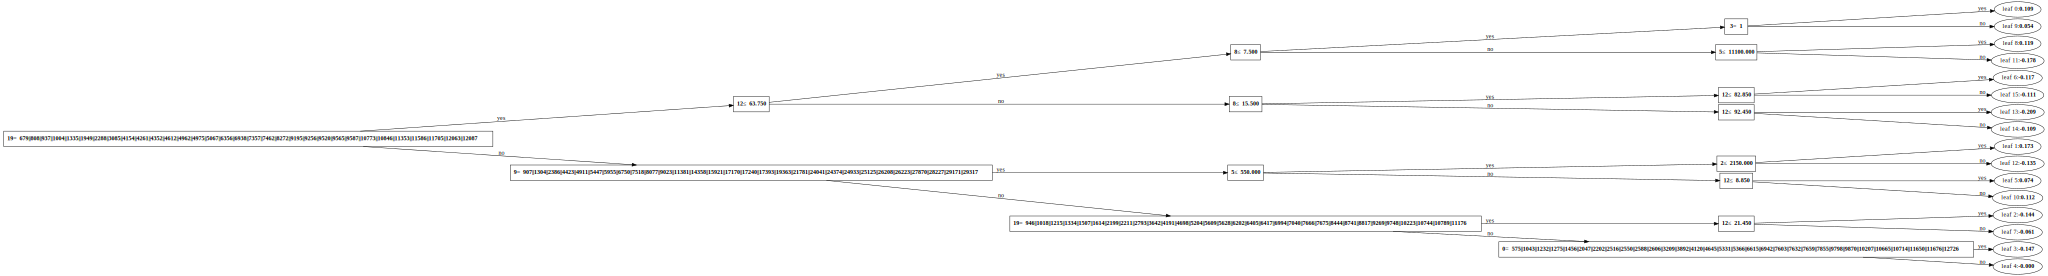

In [33]:
lgb.create_tree_digraph(model,tree_index=model.best_iteration-1,)

In [50]:
a = []
for j in range(1000):
    l = np.random.normal(loc=154.47368421052633,scale=48.64510028707142,size=5)/100
    m = 1
    for i in l:
        if i < 0:
            i = 0
        m *= i
    a.append(m)
print(np.average(a),np.std(a,ddof=1)/np.sqrt(1000))
    

8.754591438989639 0.2301926063831567


In [114]:
money = 108366220
for get in gain:
    bet = 1083000
    money -= bet
    if money <= 0:
        break
    money += bet*get/100
print(money)
    

422219620.0


In [86]:
3//2

1